In [1]:
from analysis_fns import performance, anova, learning_rates_per_width
import matplotlib.pylab as plt
import pandas as pd
import seaborn as sns
import numpy as np

In [2]:
pickle_folder='../pickles'

# Pre-Post Analysis 

### Get Data

In [27]:
# return performance in terms of ICF and Jerk 
results_per_metrics = performance(pickle_folder=pickle_folder, 
                                  phases=['pretest', 'posttest'],
                                  metrics=['icf', 'jerk', 'mvt_time'], 
                                  bounds=[0.0, 0.98])

#### Metrics 1: ICF

In [28]:
data = pd.DataFrame(results_per_metrics['icf'])

In [29]:
print(data.keys())
print(len(data))

Index(['phase', 'schedule', 'icf'], dtype='object')
861


Plots and ANOVA

In [30]:
def boxplot_factors_measure(data, factors, measure):
    ax=sns.boxplot(data=data, x=factors[0], y=measure, hue=factors[1], notch=True, showcaps=False, palette="Set2")
    sns.stripplot(data=data, x=factors[0], y=measure, hue=factors[1], palette="Set2", dodge=True, ax=ax, ec='k', linewidth=1, alpha=0.2)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:2], labels[:2], title='Phase', bbox_to_anchor=(1, 1.02), loc='upper left')
    plt.tight_layout()
    plt.show()

In [31]:
factors=['schedule', 'phase'] 

First we do an ANOVA with factors `schedule` and `phase` to see if they have an impact on `ICF`

In [33]:
print(anova(data, factors=factors, measure='icf'))

                         sum_sq     df           F        PR(>F)
C(schedule)            0.053620    2.0    1.387210  2.503327e-01
C(phase)               4.036905    1.0  208.877780  1.609072e-42
C(schedule):C(phase)   0.221874    2.0    5.740112  3.339557e-03
Residual              16.524274  855.0         NaN           NaN
None


*Result* : there is no impact of `schedule` but there is an impact of `phase` (people learn something in terms of ICF)

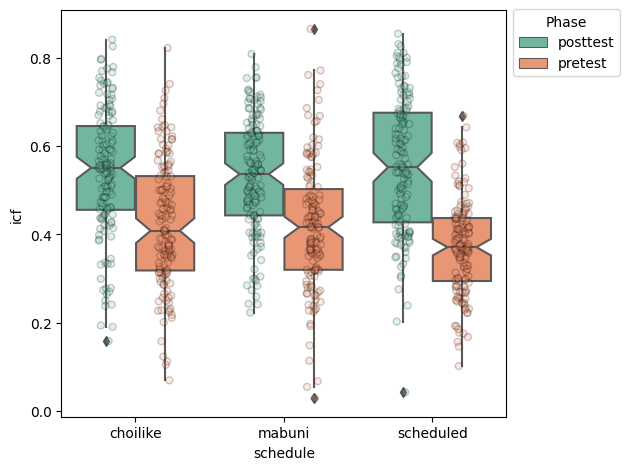

In [34]:
boxplot_factors_measure(data, factors, 'icf')

#### Metrics 2: JERK

In [36]:
data = pd.DataFrame(results_per_metrics['jerk'])

Same analysis than before: ANOVA with factors `schedule` and `phase` to see if they have an impact on `Jerk`

In [37]:
anova(data, factors=factors, measure='jerk')

                            sum_sq     df           F        PR(>F)
C(schedule)           9.857561e+05    2.0    5.840772  3.025230e-03
C(phase)              4.017415e+07    1.0  476.077324  4.611925e-84
C(schedule):C(phase)  1.853848e+05    2.0    1.098436  3.338675e-01
Residual              7.130597e+07  845.0         NaN           NaN


*Results*: Both factors have a significant impact, lets look graphically:

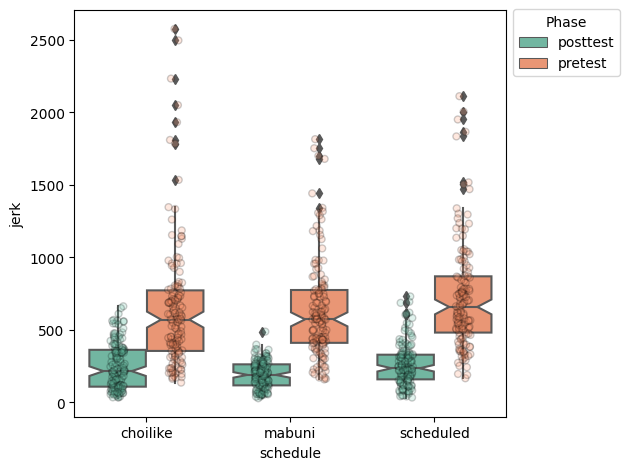

In [14]:
boxplot_factors_measure(data, factors, 'jerk')

Graphically we see that Jerk is lower at postest (people learn something in terms of Jerk) and Jerk seems lower for MAB at posttest. Let's check with a one-way ANOVA:

In [38]:
data2  = data[data['phase'] == 'posttest']
anova(data2, factors=['schedule'], measure='jerk')

                   sum_sq     df          F    PR(>F)
C(schedule)  4.209556e+05    2.0  11.524069  0.000013
Residual     7.744016e+06  424.0        NaN       NaN


`Schedule` has indeed a significant impact on `Jerk`, we can do a post-hoc analysis to see which ones are different (using pairwise t-test):

In [39]:
from scipy.stats import ttest_ind
print('MAB vs RANDOM', ttest_ind(data2[data2['schedule'] == 'mabuni']['jerk'],
        data2[data2['schedule'] == 'scheduled']['jerk']))
print('CHOI vs RANDOM',ttest_ind(data2[data2['schedule'] == 'choilike']['jerk'],
        data2[data2['schedule'] == 'scheduled']['jerk']))
print('CHOI vs MAB',ttest_ind(data2[data2['schedule'] == 'choilike']['jerk'],
        data2[data2['schedule'] == 'mabuni']['jerk']))

MAB vs RANDOM Ttest_indResult(statistic=-4.92185440687155, pvalue=1.4631506366774937e-06)
CHOI vs RANDOM Ttest_indResult(statistic=-0.4860995233726788, pvalue=0.6272727839221115)
CHOI vs MAB Ttest_indResult(statistic=4.012245976913671, pvalue=7.698247189996252e-05)


*Result* : `MAB` leads to lower Jerk compared to `RANDOM` and `CHOI`, there is no difference between `CHOI` and `RANDOM`

### Learning Rates (analysed per width)

We inspect learning rates now, although I realise that we should analyse per width as a general learning rate computed across tasks (so widths) may not make sense. At least we have to see if the width affects the learning rates. If it doesn't we can look at the aggregated learning rates across widths. 

In [16]:
rates = learning_rates_per_width(pickle_folder=pickle_folder,
               metrics=['icf', 'jerk'],
               bounds=[0., 0.98])

In [40]:
df_rates = pd.DataFrame(rates)

#### Metrics 1: ICF

Similarly than before, first we look at `ICF`

<AxesSubplot:xlabel='schedule', ylabel='icf'>

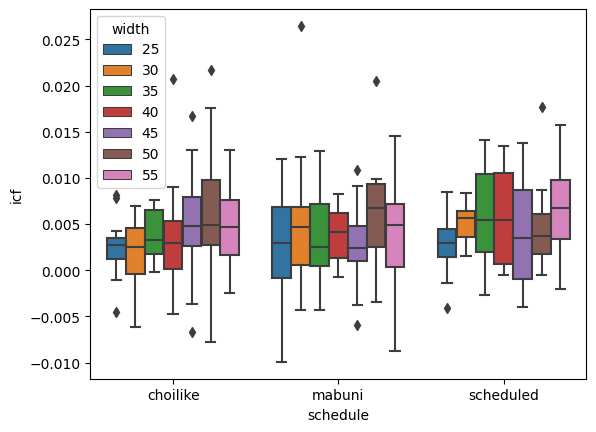

In [41]:
sns.boxplot(data=df_rates, x='schedule', hue='width', y='icf')

We look at the influence of `wdith` and `schedule` on `ICF` with a two-way ANOVA

In [42]:
anova(df_rates, factors=['width', 'schedule'], measure='icf')

                        sum_sq     df         F    PR(>F)
C(width)              0.000223    6.0  1.256418  0.278561
C(schedule)           0.000055    2.0  0.934159  0.394396
C(width):C(schedule)  0.000212   12.0  0.597103  0.843571
Residual              0.006820  231.0       NaN       NaN


*Results*: No significant difference.

#### Metrics 2: JERK

<AxesSubplot:xlabel='schedule', ylabel='jerk'>

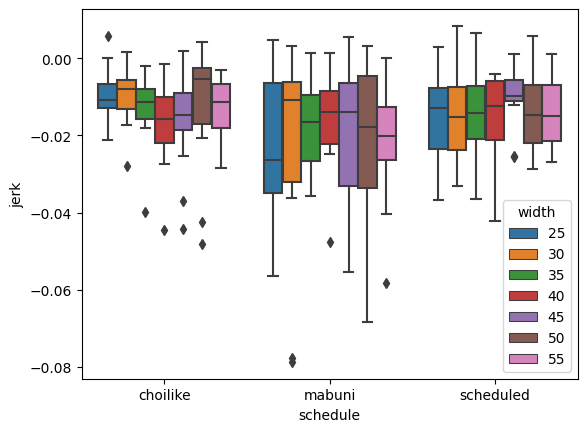

In [43]:
sns.boxplot(data=df_rates, x='schedule', hue='width', y='jerk')

Same analysis with `Jerk`...

In [44]:
anova(df_rates, factors=['width', 'schedule'], measure='jerk')

                        sum_sq     df         F    PR(>F)
C(width)              0.000120    6.0  0.093817  0.996924
C(schedule)           0.002848    2.0  6.672918  0.001523
C(width):C(schedule)  0.001432   12.0  0.559126  0.873306
Residual              0.049299  231.0       NaN       NaN


The two-way ANOVA above shows that there is no significant influence of width but there is of schedule, therefore we can aggregate data along the width and do a one-way anova with factor `schedule`

In [45]:
anova(df_rates, factors=['schedule'], measure='jerk')

               sum_sq     df         F    PR(>F)
C(schedule)  0.002848    2.0  6.973349  0.001131
Residual     0.050851  249.0       NaN       NaN


The ANOVA shows a significant effect of `schedule`, so we can do post-how analysis: basically pairwise T-Tests ...

In [46]:
from scipy.stats import ttest_ind
print('MAB vs RANDOM', ttest_ind(df_rates[df_rates['schedule'] == 'mabuni']['jerk'],
        df_rates[df_rates['schedule'] == 'scheduled']['jerk']))
print('CHOI vs RANDOM',ttest_ind(df_rates[df_rates['schedule'] == 'choilike']['jerk'],
        df_rates[df_rates['schedule'] == 'scheduled']['jerk']))
print('CHOI vs MAB',ttest_ind(df_rates[df_rates['schedule'] == 'choilike']['jerk'],
        df_rates[df_rates['schedule'] == 'mabuni']['jerk']))

MAB vs RANDOM Ttest_indResult(statistic=-2.861333436323076, pvalue=0.004761695979477344)
CHOI vs RANDOM Ttest_indResult(statistic=0.2633151570094376, pvalue=0.7926342349933243)
CHOI vs MAB Ttest_indResult(statistic=3.0378670972517403, pvalue=0.00276810233325971)


`MAB` is significant lower than `CHOI` and `RANDOM` meaning that people learn **faster** with MAB